In [38]:
import matplotlib.pyplot as plt
import os
import glob
from scipy import ndimage

from Utils import *
from Utils_AlignVolumes import *

# Crop to Particles

In [78]:
MRC = ".mrc"
RAW = ".raw"

gt_path = r"./Reconstructions\Real_Nanoparticles\L2Clean/"
gt_format = RAW

vol_path = r"./Reconstructions\Real_Nanoparticles\Ours/"
vol_format = RAW

save_to = vol_path+"/RAW/"

resolution = 512
voxel_type = 'uint8' #'uint16'

### Load stuff

In [79]:
vol_path = glob.glob(vol_path+"/*"+vol_format)[0]
print("Volume Path: "+str(vol_path))

os.makedirs(save_to, exist_ok=True)

Volume Path: C:\Users\Hannah\Documents\ABEM\_SW\CVPR_GIT\Implicit-Electron-Tomography\Reconstruction\Tomograms\Nanoparticles\Ours_New\volume.raw


In [80]:
if(vol_format == MRC):
    volume = open_mrc(vol_path)
else: 
    volume = open_raw(vol_path, voxel_type)
volume = min_max(volume)
print("Volume init shape: "+str(volume.shape))

if(gt_format == MRC):
    volume_gt = open_mrc(gt_path)
else: 
    volume_gt = open_raw(gt_path, 'uint8')
volume_gt = min_max(volume_gt)
print("GT init shape: "+str(volume_gt.shape))


Max loaded data: 255
Volume init shape: (512, 512, 512)
Max loaded data: 255
GT init shape: (512, 512, 512)


### Align

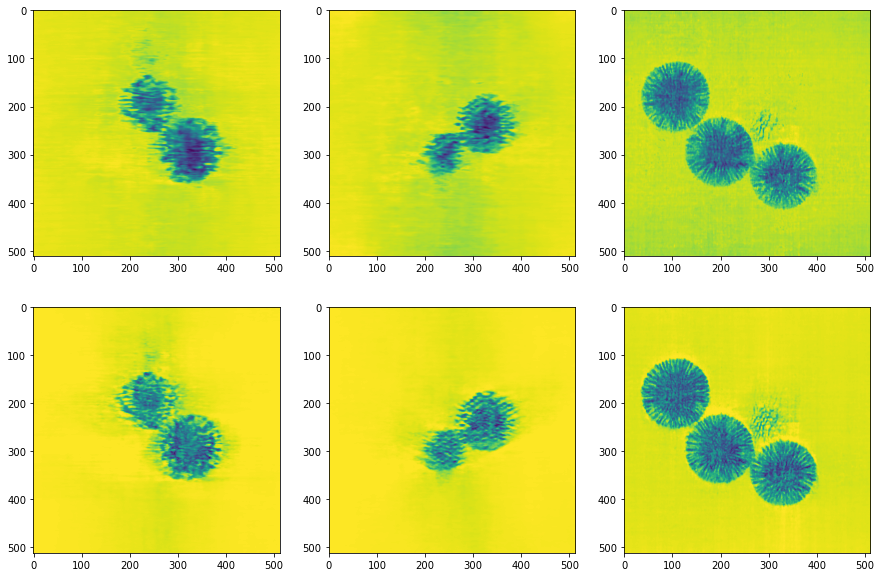

In [81]:
m_vol = volume.shape[0]//2
m_gt = volume_gt.shape[0]//2

fig, axs = plt.subplots(2,3, figsize=(15,10))
axs[0,0].imshow(volume[m_vol,:,:])
axs[1,0].imshow(volume_gt[m_gt,:,:])

axs[0,1].imshow(volume[:,m_vol,:])
axs[1,1].imshow(volume_gt[:,m_gt,:])

axs[0,2].imshow(volume[:,:,m_vol])
axs[1,2].imshow(volume_gt[:,:,m_gt])

plt.show()

The volume might need to be transposed and/or flipped in order to match the ground truth. 

In [562]:
# volume = volume.transpose(2,0,1) #transpose
# volume = volume[:,:,::-1] #flip
# volume = 1 - volume #invert

## Binarize

In [82]:
from skimage.filters import threshold_otsu
thresh = threshold_otsu(volume_gt)
otsu_mask = volume_gt <= thresh

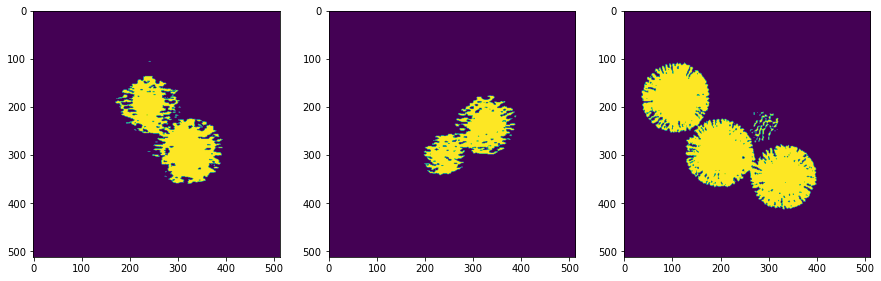

In [83]:
fig, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(otsu_mask[m_gt,:,:])

axs[1].imshow(otsu_mask[:,m_gt,:])

axs[2].imshow(otsu_mask[:,:,m_gt])

plt.show()

## Dilation Filter

In [84]:
mask = ndimage.binary_dilation(otsu_mask, iterations = 10)

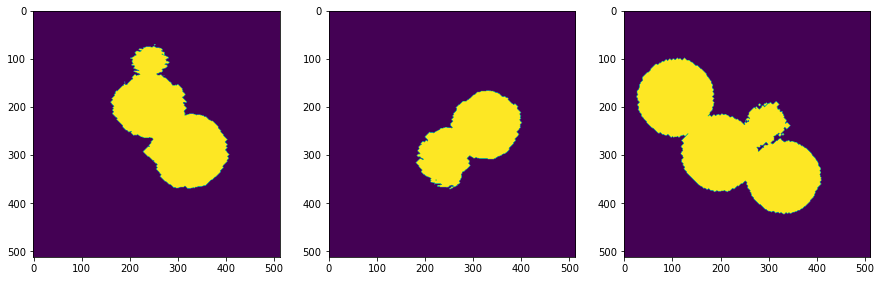

In [85]:
fig, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(mask[m_gt,:,:])

axs[1].imshow(mask[:,m_gt,:])

axs[2].imshow(mask[:,:,m_gt])

plt.show()

## Show final Mask

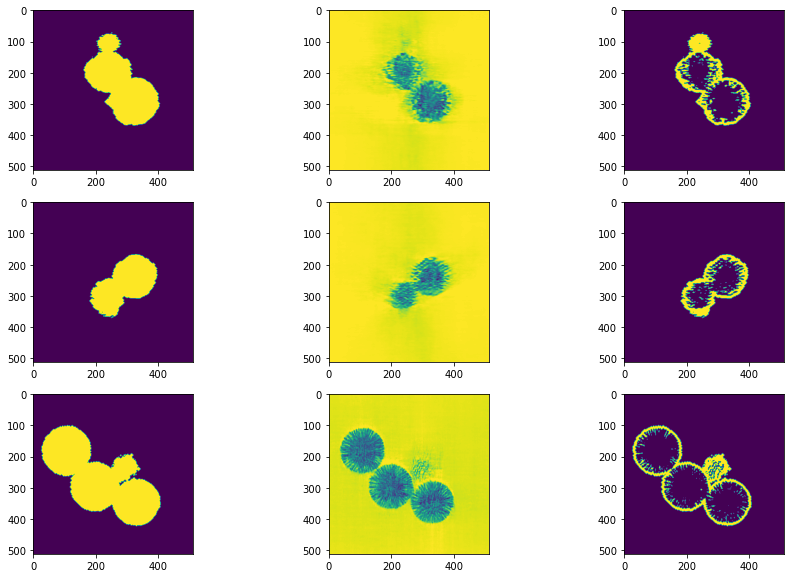

In [86]:
m_gt = mask.shape[0]//2

fig, axs = plt.subplots(3,3, figsize=(15,10))
axs[0,0].imshow(mask[m_gt,:,:])
axs[0,1].imshow(volume_gt[m_gt,:,:])
axs[0,2].imshow(mask[m_gt,:,:].astype(np.int32)-otsu_mask[m_gt,:,:].astype(np.int32))

axs[1,0].imshow(mask[:,m_gt,:])
axs[1,1].imshow(volume_gt[:,m_gt,:])
axs[1,2].imshow(mask[:,m_gt,:].astype(np.int32)-otsu_mask[:,m_gt,:].astype(np.int32))


axs[2,0].imshow(mask[:,:,m_gt])
axs[2,1].imshow(volume_gt[:,:,m_gt])
axs[2,2].imshow(mask[:,:,m_gt].astype(np.int32)-otsu_mask[:,:,m_gt].astype(np.int32))

plt.show()

## Show Error

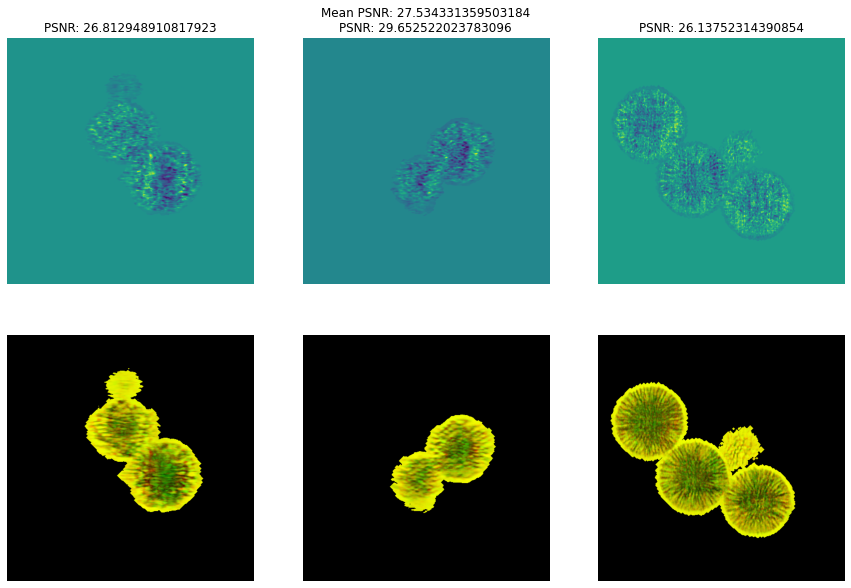

In [87]:
save_shape = volume_gt.shape

comparison = np.zeros_like(volume_gt)
comparison = comparison.reshape(-1)
comparison[mask.reshape(-1)] = volume.reshape(-1)[mask.reshape(-1)]
comparison = comparison.reshape(save_shape)

comparison_gt = np.zeros_like(volume_gt)
comparison_gt = comparison_gt.reshape(-1)
comparison_gt[mask.reshape(-1)] = volume_gt.reshape(-1)[mask.reshape(-1)]
comparison_gt = comparison_gt.reshape(save_shape)

difference = comparison - comparison_gt
overlay = np.zeros((save_shape[0], save_shape[1], save_shape[2], 3))
overlay[:,:,:,0] = comparison
overlay[:,:,:,1] = comparison_gt

slice1_psnr,_ = psnr(comparison_gt[m_gt,:,:], comparison[m_gt,:,:], slices = False)
slice2_psnr,_ = psnr(comparison_gt[:,m_gt,:], comparison[:,m_gt,:], slices = False)
slice3_psnr,_ = psnr(comparison_gt[:,:,m_gt], comparison[:,:,m_gt], slices = False)


fig, axs = plt.subplots(2,3, figsize=(15,10))
axs[0,0].imshow(difference[m_gt,:,:])
axs[0,0].set_axis_off()
axs[0,0].set_title("PSNR: "+str(slice1_psnr))

axs[1,0].imshow(overlay[m_gt,:,:])
axs[1,0].set_axis_off()


axs[0,1].imshow(difference[:,m_gt,:])
axs[0,1].set_axis_off()
axs[0,1].set_title("Mean PSNR: "+str(np.mean([slice1_psnr, slice2_psnr, slice3_psnr]))+"\nPSNR: "+str(slice2_psnr))


axs[1,1].imshow(overlay[:,m_gt,:])
axs[1,1].set_axis_off()


axs[0,2].imshow(difference[:,:,m_gt])
axs[0,2].set_axis_off()
axs[0,2].set_title("PSNR: "+str(slice3_psnr))


axs[1,2].imshow(overlay[:,:,m_gt])
axs[1,2].set_axis_off()
plt.savefig(save_to+"/error.pdf")

plt.show()



## Compute Error

In [88]:
vol_gt = volume_gt.reshape(-1)
vol_gt = vol_gt[mask.reshape(-1)]

vol_compare = volume.reshape(-1)
vol_compare = vol_compare[mask.reshape(-1)]


psnr_val = psnr(vol_gt.astype(np.float16), vol_compare.astype(np.float16), slices = False)
mse_val = mse(vol_gt, vol_compare, slices = False)

eval_str = "PSNR: "+str(psnr_val)+" | MSE: "+str(mse_val)
print(eval_str)

PSNR: (19.536696133726146, 0) | MSE: (0.01112433479677886, 0)


In [640]:
# Save args params
f = open(save_to+"/eval.txt", "w")
f.write(eval_str)
f.close()